# Transfer Learning with TensorFlow part 2: Fine-Tuning

 In the previous notebook, we covered transfer earning feature extraction. Now it's time to learn about a new kind of transfer learning fine tuning

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-02 17:32:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-02 17:32:48 (99.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import hepler functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-04-02 17:32:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.0MB/s    in 8.1s    

2023-04-02 17:33:00 (20.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("10_food_classes_10_percent.zip")

In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE=(224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[5.14642868e+01 4.24642868e+01 6.41530609e+01]
   [4.08622475e+01 3.66020432e+01 5.16224518e+01]
   [3.91173477e+01 4.35459213e+01 4.54744873e+01]
   ...
   [3.40100136e+01 2.28569679e+01 1.68569679e+01]
   [2.85355644e+01 2.18417416e+01 1.17498884e+01]
   [2.66889477e+01 2.51481762e+01 1.31481762e+01]]

  [[5.29336739e+01 4.80306129e+01 6.39081650e+01]
   [5.63214264e+01 5.43214264e+01 6.53214264e+01]
   [4.31020393e+01 4.76887779e+01 4.79744911e+01]
   ...
   [3.25662460e+01 1.74233894e+01 1.03519611e+01]
   [3.53977852e+01 2.53314838e+01 1.61937046e+01]
   [3.39031639e+01 2.84236355e+01 1.64950638e+01]]

  [[3.86071434e+01 3.77448997e+01 4.68928604e+01]
   [2.24693871e+01 2.54132652e+01 2.96428585e+01]
   [5.89540787e+01 6.55969315e+01 6.33826523e+01]
   ...
   [4.17857361e+01 2.40000229e+01 1.44285936e+01]
   [4.00101662e+01 2.63826447e+01 1.57397747e+01]
   [4.10249901e+01 3.04434128e+01 1.86576977e+01]]

  ...

  [[2.17566315e+02 1.75566315e+02 1.51566315e+02]
   [2

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibilit with our models.

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (the underlying pre-trained patterns aren't updated during the training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50v2 you will need to normalize inputs (don't have to when using efficient net)
x = tf.keras.layers.Rescaling(1./255)(inputs)

# 5.Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model")

# 6. Average pool the outputs of the base model (aggregate all the most important niformation, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8.Combine the inputs with the outputs into the model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        steps_per_epoch=len(train_data_10_percent),
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)))

16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base model
Shape after GlobalAveragePooling2D: (None, 1280)
Epoch 1/5
24/24 [==============================] - 23s 350ms/step - loss: 1.8673 - accuracy: 0.4253 - val_loss: 1.3120 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - 4s 141ms/step - loss: 1.1010 - accuracy: 0.7480 - val_loss: 0.8850 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 5s 176ms/step - loss: 0.7947 - accuracy: 0.8080 - val_loss: 0.7189 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 4s 138ms/step - loss: 0.6382 - accuracy: 0.8600 - val_loss: 0.5968 - val_accuracy: 0.8684
Epoch 5/5
24/24 [==============================] - 4s 145ms/step - loss: 0.5465 - accuracy: 0.8813 - val_loss: 0.5431 - val_accuracy: 0.8783


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5599 - accuracy: 0.8596


[0.5598533153533936, 0.8596000075340271]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [13]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

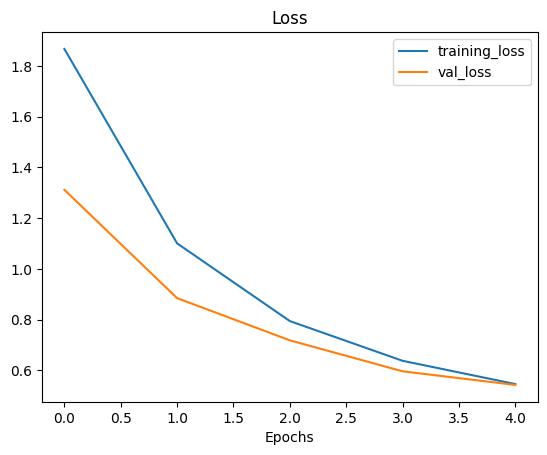

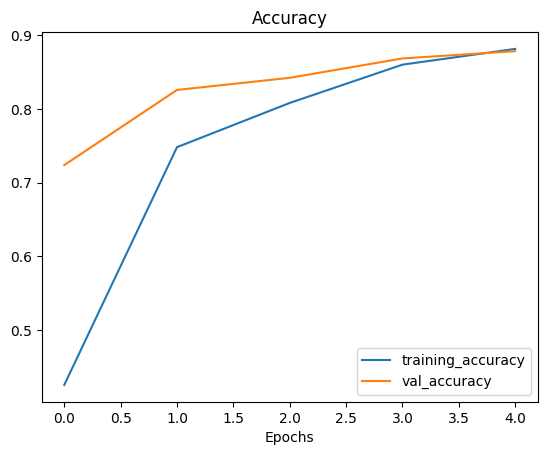

In [14]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turnd into (None, 1280).

Let's use a similar shapes tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [15]:
# Set random seed
tf.random.set_seed(42)

# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"shape of input tensor {input_tensor.shape}")
print(f"shape of global average pooled tensor {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor (1, 4, 4, 3)
shape of global average pooled tensor (1, 3)


In [16]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augumentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augumentation
3. `model_3` - use fine tuning transfer learning on 10% of the training data with data augumentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augumentation

## Getting and preprocessing data for `model_1`

In [17]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-04-02 17:34:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.7MB/s    in 6.5s    

2023-04-02 17:34:17 (19.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [30]:
# Create training and test dirs
train_dir_1_percent = "/content/10_food_classes_1_percent/train/"
test_dir = "/content/10_food_classes_1_percent/test/"

In [31]:
# How many images are we working with
walk_through_dir("/content/10_food_classes_1_percent")

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_1_pe

In [32]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

test_dir = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augumentation right into the model

To add data augumentation right into our models, we can use the layers inside:

* `tf.keras.layers`

We can see the benefits of doing this within the TensorFlow Data augumentation documentation

Off the top of our heads, after reading the docs, the benefits of using data augumentation inside the model are:
* Preprocessing of images (augumenting them) happens on the GPU (much faster) rather than on the CPU.
* Image data augumentation only happens during training, so we can still export our whole model and use it elsewhere

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth

# Create data augumentation stage horizontal flipping, rotations, zooms, etc
data_augumentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    # RandomRescale(1./255), # Keep for models like resnet50v2. Unnecessary for efficient net models (they have it built in)
], name="data_augumentation")



### Visualize our data augumentation layer (and see what happens to our data)

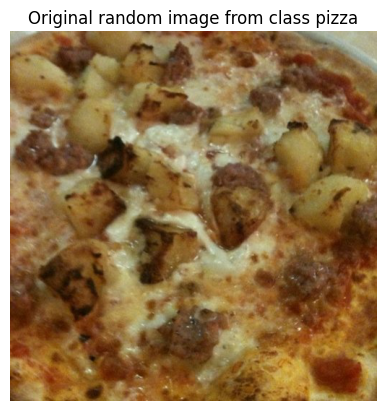

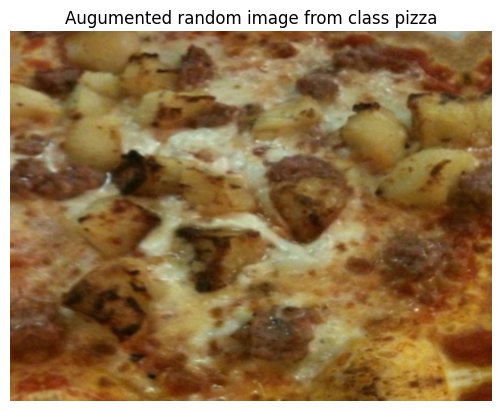

In [44]:
# View a random image and compare it to its augumented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augumented random image
augumented_img = data_augumentation(tf.expand_dims(img, axis=0))

plt.figure()
plt.imshow(tf.squeeze(augumented_img)/ 255.)
plt.title(f"Augumented random image from class {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augumentation

In [45]:
# Setup the input shape and base model, freezing the base model laeyrs
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augumentation Sequential model as a layer
x = data_augumentation(inputs)

# Give base_model the inputs (after augumentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                steps_per_epoch=len(train_data_1_percent),
                                epochs=5,
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230402-183614
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.2784 - accuracy: 0.1286 - val_loss: 2.1289 - val_accuracy: 0.2664
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0026 - accuracy: 0.3714 - val_loss: 1.9909 - val_accuracy: 0.3668
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8539 - accuracy: 0.4429 - val_loss: 1.9052 - val_accuracy: 0.4424
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7061 - accuracy: 0.5857 - val_loss: 1.8017 - val_accuracy: 0.4885
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5340 - accuracy: 0.7429 - val_loss: 1.7068 - val_accuracy: 0.5214


In [47]:
# Check out a model summary
model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augumentation (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [48]:
# Evaluate on the full test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 1.7157 - accuracy: 0.5348


[1.7156673669815063, 0.5347999930381775]

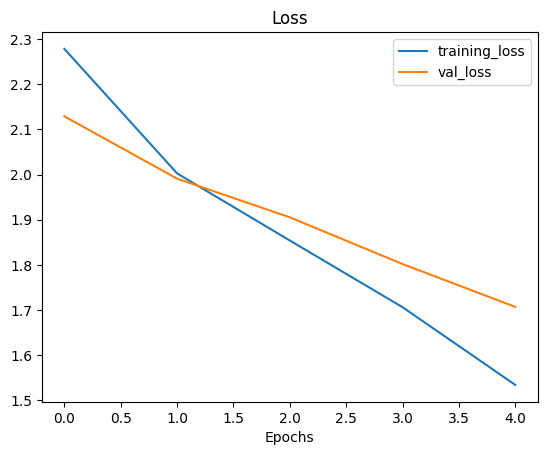

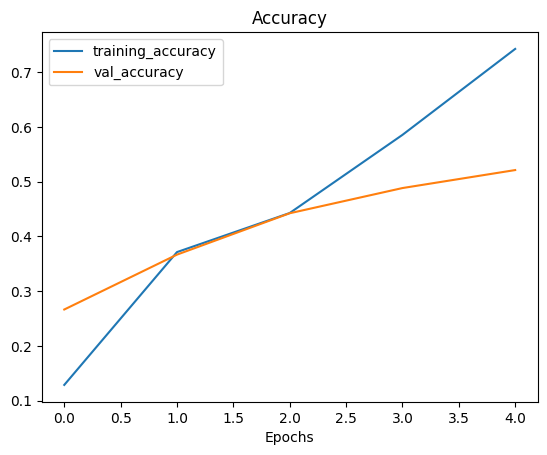

In [50]:
# How does the model with 1% of the train data go with data augumentation
plot_loss_curves(history_1_percent)

In [51]:
# Setup the input shape and base model freezing the top layers
input_shape=(224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augumentation
x = data_augumentation(inputs)

# Give base model the inputs and dont train it
x = base_model(x, training=False)

# Pool output features out of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# Put out a Dense layer as an output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2_10_percent = model_2.fit(train_data_10_percent,
                                   steps_per_epoch=len(train_data_10_percent),
                                   epochs=5,
                                   validation_data=test_data,
                                   validation_steps=int(0.25 * len(test_data)),
                                   callbacks=[create_tensorboard_callback("transfer_learning",
                                                                          "10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230402-184733
Epoch 1/5
24/24 [==============================] - 22s 577ms/step - loss: 1.9944 - accuracy: 0.3347 - val_loss: 1.4424 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 12s 494ms/step - loss: 1.3149 - accuracy: 0.6893 - val_loss: 0.9702 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 11s 433ms/step - loss: 0.9873 - accuracy: 0.7840 - val_loss: 0.7881 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 13s 516ms/step - loss: 0.8507 - accuracy: 0.8120 - val_loss: 0.6891 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 11s 451ms/step - loss: 0.7419 - accuracy: 0.8240 - val_loss: 0.6101 - val_accuracy: 0.8503


In [52]:
# Evaluate the model
model_2.evaluate(test_data)

79/79 [==============================] - 9s 102ms/step - loss: 0.6302 - accuracy: 0.8428


[0.6301974654197693, 0.8428000211715698]

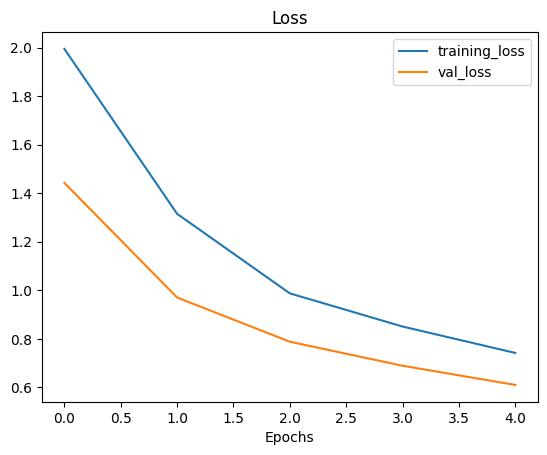

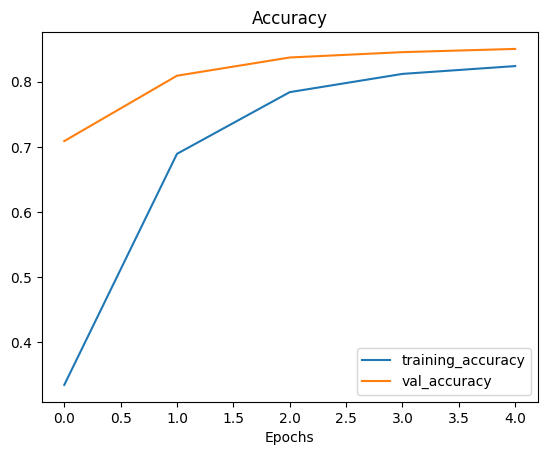

In [53]:
# Plot loss curves
plot_loss_curves(history_2_10_percent)

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful, so we can come and start where we left off.

In [54]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1) 

### Fit model 2 passing in the ModelCheckpoint callback

In [55]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          steps_per_epoch=len(train_data_10_percent),
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                 "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230402-191035


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.8373
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 474ms/step - loss: 0.6655 - accuracy: 0.8373 - val_loss: 0.5542 - val_accuracy: 0.8569
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 0.8440
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 393ms/step - loss: 0.6210 - accuracy: 0.8440 - val_loss: 0.5107 - val_accuracy: 0.8635
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.8613
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 443ms/step - loss: 0.5679 - accuracy: 0.8613 - val_loss: 0.5152 - val_accuracy: 0.8618
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.

In [56]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5024 - accuracy: 0.8548


[0.5024203062057495, 0.8547999858856201]

In [57]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 95ms/step - loss: 0.5599 - accuracy: 0.8596


[0.5598531365394592, 0.8596000075340271]

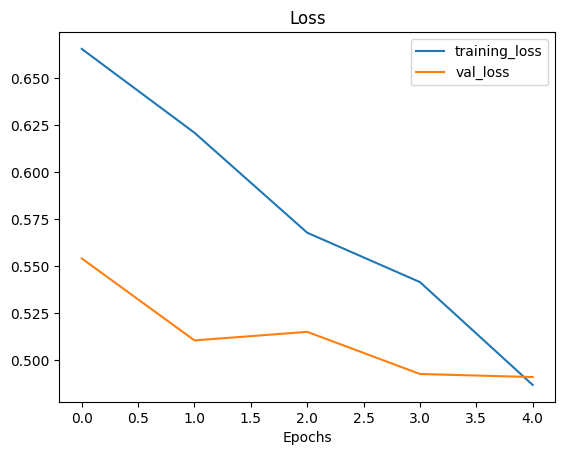

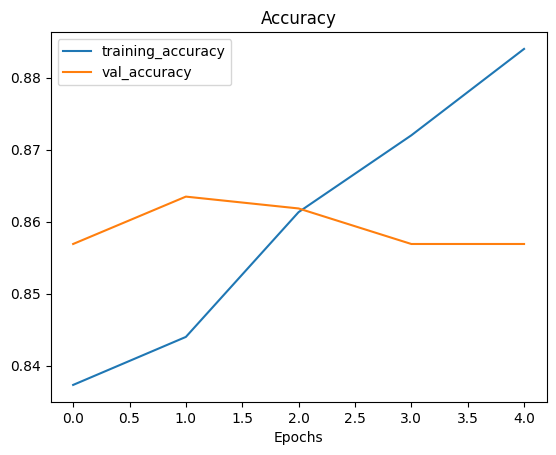

In [59]:
# Plot loss curves
plot_loss_curves(history_10_percent_data_aug)